In [1]:
import torch
import pandas as pd
import numpy as np
import sklearn
from collections import Counter

In [2]:
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
from itertools import combinations

In [4]:
import re
import os

In [5]:
import torch.nn as nn

In [6]:
import matplotlib.pyplot as plt

# Data Loading

In [7]:
path = "data/fox_news.csv"
df = pd.read_csv(path, index_col=0)
df = df.rename(columns={'class': 'label'})
df.head()

,text,label
0,barryswallows Merkel would never say NO,1
1,PostApocalypticHero Expect more and more women...,1
2,californiamojo Groping people in public wasn't...,0
3,"MikeSte Merkel, possible the only person in ch...",1
4,"scientist They know very well, no means NO! Th...",1


In [8]:
path = 'data/all_movies.csv'
movie_data = pd.read_csv(path, index_col=0)

In [9]:
movie_data.head()

,movie_name,index,utterance,count_utterances,tag
0,12 Angry Men,0,"Thank you very much, sir.",2065,racism
1,12 Angry Men,1,You did a wonderful job. Wonderful.,2065,racism
2,12 Angry Men,2,Shh. Shh.,2065,racism
3,12 Angry Men,3,"We did it, Pete. We did it.",2065,racism
4,12 Angry Men,4,"For a moment, we had our doubts.",2065,racism


0    2186
1     870
Name: label, dtype: int64


array([<AxesSubplot:ylabel='label'>], dtype=object)

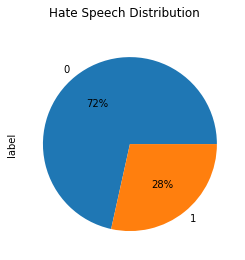

In [10]:
print(df.label.value_counts())
df.label.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Hate Speech Distribution')

## Data Cleansing

In [11]:
def filter_hatespeech_texts(df):
    
    def filter_texts(text):
        text = re.sub('@.\:|!|@\w+|&#[0-9]*;|#\w+|RT|\/\/t.co\/\w+|&gt|&lt', '', text)
        return text

    df['text'] = df['text'].apply(filter_texts)
    df.replace("", np.nan, inplace=True)
    df = df.dropna()
    
    return df

In [12]:
df = filter_hatespeech_texts(df)
df = filter_hatespeech_texts(df)

In [13]:
df.head()

,text,label
0,barryswallows Merkel would never say NO,1
1,PostApocalypticHero Expect more and more women...,1
2,californiamojo Groping people in public wasn't...,0
3,"MikeSte Merkel, possible the only person in ch...",1
4,"scientist They know very well, no means NO The...",1


## Data Splitting

In [14]:
def split_dataset(df, seed, test_size):
    train, test = train_test_split(df, test_size=test_size, random_state=seed, shuffle=True)
    return train.text.values, train.label.values, test.text.values, test.label.values

In [15]:
# categories = ['not hate speech', 'hate speech]
categories = [0,1]
seed = 11
test_size = 0.2

In [16]:
train, train_targets, test, test_targets = split_dataset(df, seed=seed, test_size=test_size)

In [17]:
train_size = len(train)
test_size = len(test)

In [18]:
def calculate_dataset_class_distribution(targets, categories):
    df = pd.DataFrame({'category':targets})
    s = df.category.value_counts(normalize=True)
    s = s.reindex(categories)
    return [s.index[0], s[0]], [s.index[1], s[1]]

In [19]:
train_class_distribution = calculate_dataset_class_distribution(train_targets, categories)
test_class_distribution = calculate_dataset_class_distribution(test_targets, categories)

In [20]:
train_ds = Bunch(data=train, target=train_targets)
test_ds = Bunch(data=test, target=test_targets)

## Buidling the Model

In [21]:
# Getting all the vocabularies and indexing to a unique position
vocab = Counter()
#Indexing words from the training data
for text in train_ds.data:
    for word in text.split(' '):
        vocab[word.lower()]+=1

#Indexing words from the training data
for text in test_ds.data:
    for word in text.split(' '):
        vocab[word.lower()]+=1

for text in movie_data.utterance.values:
    for word in text.split(' '):
        vocab[word.lower()]+=1
        
total_words = len(vocab)

def get_word_2_index(vocab):
    word2index = {}
    for i,word in enumerate(vocab):
        word2index[word.lower()] = i

    return word2index

word2index = get_word_2_index(vocab)

In [22]:
print(len(word2index))
print(word2index["the"]) # Showing the index of 'the'
print (total_words)

114912
34
114912


In [23]:
# define the network
class News_20_Net(nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
        super(News_20_Net, self).__init__()
        self.layer_1 = nn.Linear(input_size,hidden_size, bias=True).cuda()
        self.relu = nn.ReLU().cuda()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True).cuda()
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True).cuda()
    # accept input and return an output
     def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

In [24]:
def get_batch(df,i,batch_size):
    batches = []
    results = []
    # Split into different batchs, get the next batch 
    texts = df.data[i*batch_size:i*batch_size+batch_size]
    # get the targets 
    categories = df.target[i*batch_size:i*batch_size+batch_size]
    #print(categories)
    for text in texts:
        # Dimension, 196609
        layer = np.zeros(total_words,dtype=float)

        for word in text.split(' '):
            layer[word2index[word.lower()]] += 1
        batches.append(layer)

    # We have 5 categories
    for category in categories:
        #print(category)
        index_y = -1
        if category == 0:
            index_y = 0
        elif category == 1:
            index_y = 1
        elif category == 2:
            index_y = 2
        results.append(index_y)

    # the training and the targets
    return np.array(batches),np.array(results)

In [25]:
# Parameters
learning_rate = 0.001
num_epochs = 8
batch_size = 32
display_step = 1 # ADDED will multiplied by 10

# Network Parameters
hidden_size = 100      # 1st layer and 2nd layer number of features
input_size = total_words # Words in vocab
num_classes = len(categories)         # Categories: "graphics","space","baseball","guns", "christian"

## Training

In [26]:
results = []

In [27]:
news_net = News_20_Net(input_size, hidden_size, num_classes)
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # This includes the Softmax loss function
optimizer = torch.optim.Adam(news_net.parameters(), lr=learning_rate)  

# Train the Model
for epoch in range(num_epochs):
    # determine the number of min-batches based on the batch size and size of training data
    total_batch = int(len(train_ds.data)/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x,batch_y = get_batch(train_ds,i,batch_size)
        
        articles = torch.cuda.FloatTensor(batch_x, device='cuda')
        labels = torch.cuda.LongTensor(batch_y, device='cuda')

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = news_net(articles)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % display_step == 0:
            result = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f'%(epoch+1, num_epochs, i+1, len(train_ds.data)/batch_size, loss.data)
            results.append({'Epoch': epoch+1, 'Step': i+1, 'Loss': loss.data.item()})
            if (i+1) % (display_step*10) == 0:
                print({'Epoch': epoch+1, 'Step': i+1, 'Loss': loss.data.item()})

{'Epoch': 1, 'Step': 10, 'Loss': 0.6728976964950562}
{'Epoch': 1, 'Step': 20, 'Loss': 0.6108188629150391}
{'Epoch': 1, 'Step': 30, 'Loss': 0.6024702787399292}
{'Epoch': 1, 'Step': 40, 'Loss': 0.478333443403244}
{'Epoch': 1, 'Step': 50, 'Loss': 0.5201638340950012}
{'Epoch': 1, 'Step': 60, 'Loss': 0.34656694531440735}
{'Epoch': 1, 'Step': 70, 'Loss': 0.5303338170051575}
{'Epoch': 2, 'Step': 10, 'Loss': 0.29577165842056274}
{'Epoch': 2, 'Step': 20, 'Loss': 0.29947778582572937}
{'Epoch': 2, 'Step': 30, 'Loss': 0.15183094143867493}
{'Epoch': 2, 'Step': 40, 'Loss': 0.10003000497817993}
{'Epoch': 2, 'Step': 50, 'Loss': 0.06609705835580826}
{'Epoch': 2, 'Step': 60, 'Loss': 0.04118756204843521}
{'Epoch': 2, 'Step': 70, 'Loss': 0.10062792897224426}
{'Epoch': 3, 'Step': 10, 'Loss': 0.03320088982582092}
{'Epoch': 3, 'Step': 20, 'Loss': 0.020052503794431686}
{'Epoch': 3, 'Step': 30, 'Loss': 0.03360023722052574}
{'Epoch': 3, 'Step': 40, 'Loss': 0.024990303441882133}
{'Epoch': 3, 'Step': 50, 'Loss': 

## Validation

In [28]:
# Test the Model
correct = 0
total = 0
total_test_data = len(test_ds.target)

In [29]:
iterates = total_test_data/batch_size # ignore last (<batch_size) batch

In [30]:
all_total = []
all_correct = []
labels_all = []
predicted_all = []

In [31]:
for i in range(int(iterates)):
    batch_x_test,batch_y_test = get_batch(test_ds,i,batch_size)
    
    articles = torch.FloatTensor(batch_x_test).to('cuda')
    
    labels = torch.LongTensor(batch_y_test).to('cuda')
    outputs = news_net(articles)
    _, predicted = torch.max(outputs.data, 1)
    
    labels_all.extend([x.item() for x in labels])
    predicted_all.extend([x.item() for x in predicted])

In [32]:
categories = ['not hate speech', 'hate speech']

In [33]:
report = classification_report(labels_all, predicted_all, target_names=categories, output_dict=True)

In [34]:
df_report = pd.DataFrame(report).transpose()

In [35]:
df_report

,precision,recall,f1-score,support
not hate speech,0.938095,0.956311,0.947115,412.000000
hate speech,0.904255,0.867347,0.885417,196.000000
accuracy,0.927632,0.927632,0.927632,0.927632
macro avg,0.921175,0.911829,0.916266,608.000000
weighted avg,0.927186,0.927632,0.927226,608.000000


In [36]:
df_results = pd.DataFrame(results)

In [37]:
df_results['learning_rate'] = learning_rate
df_results['num_epochs'] = num_epochs
df_results['batch_size'] = batch_size
df_results['num_classes'] = num_classes
df_results['test_size'] = test_size
df_results['train_size'] = train_size
df_results['seed'] = seed
df_results['test_size'] = test_size
df_results['train_class_proportion_' + categories[0]] = round(train_class_distribution[0][1], 2)
df_results['train_class_proportion_' + categories[1]] = round(train_class_distribution[1][1], 2)
df_results['test_class_proportion_' + categories[0]] = round(test_class_distribution[0][1], 2)
df_results['test_class_proportion_' + categories[1]] = round(test_class_distribution[1][1], 2)

In [38]:
df_results.head()

,Epoch,Step,Loss,learning_rate,num_epochs,batch_size,num_classes,test_size,train_size,seed,train_class_proportion_not hate speech,train_class_proportion_hate speech,test_class_proportion_not hate speech,test_class_proportion_hate speech
0,1,1,0.707816,0.001,8,32,2,612,2444,11,0.73,0.27,0.68,0.32
1,1,2,0.701499,0.001,8,32,2,612,2444,11,0.73,0.27,0.68,0.32
2,1,3,0.695859,0.001,8,32,2,612,2444,11,0.73,0.27,0.68,0.32
3,1,4,0.689004,0.001,8,32,2,612,2444,11,0.73,0.27,0.68,0.32
4,1,5,0.694559,0.001,8,32,2,612,2444,11,0.73,0.27,0.68,0.32


In [39]:
name = 'training_logs_word_embedding_fox_news.csv'

In [40]:
df_results.to_csv(name)

In [41]:
name = 'matrix_report_fox_news.csv'

In [42]:
df_report.to_csv(name)

In [43]:
def plot_loss(path, ax, title):
    df = pd.read_csv(path)
    df.groupby('Epoch').Loss.plot(kind='line', legend=True, title=title, ax=ax, figsize=(15,8))
    ax.legend(loc='upper right')
    plt.xlabel('Step') 
    plt.ylabel('Loss')

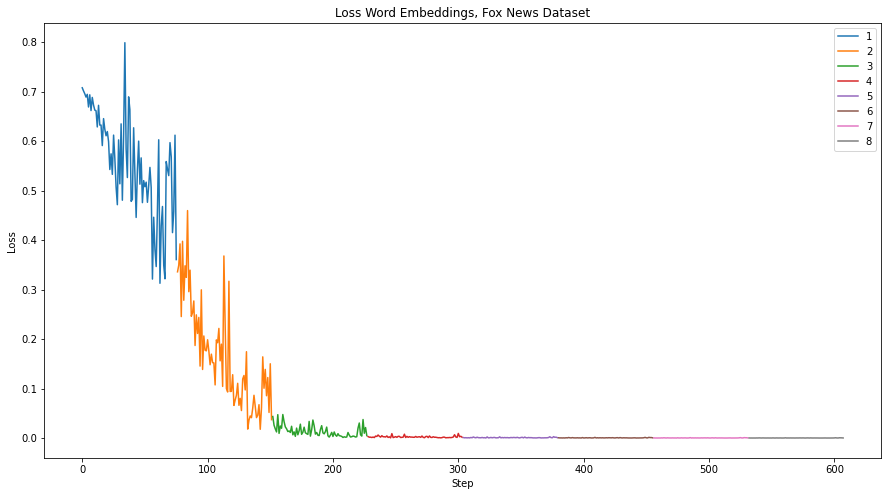

In [44]:
fig, axs = plt.subplots(1,1)
path = './training_logs_word_embedding_fox_news.csv'
plot_loss(path, axs, title='Loss Word Embeddings, Fox News Dataset')

----

## Classication of Movies

### Load Movies

In [45]:
def read_movie_files(pathes):
    result = []
    for path in pathes: 
        directory = os.fsencode(path)

        for file in os.listdir(directory):
            filename = os.fsdecode(file)

            if filename.endswith(".csv"):
                #print(os.path.join(directory, filename))
                #local_df = read_content(path + '//' + filename)
                movie_df = pd.read_csv(path + '//' + filename)
                tag = path.split('/')[1]
                count_utterances = movie_df.shape[0]
                result.append({'movie_name': filename[:-9], 'count_utterances': count_utterances, 'tag': tag, 'path': path + '//' + filename})
    result_df = pd.DataFrame(result)
    return result_df

In [46]:
pathes = ['movies/racism', 'movies/hate_speech', 'movies/friendship']

In [47]:
movie_metadata_df = read_movie_files(pathes)

In [48]:
movie_metadata_df.head()

,movie_name,count_utterances,tag,path
0,12 Angry Men,2065,racism,movies/racism//12 Angry Men_conv.csv
1,12 Years a Slave,110,racism,movies/racism//12 Years a Slave_conv.csv
2,42,1288,racism,movies/racism//42_conv.csv
3,A Bronx Tale,1961,racism,movies/racism//A Bronx Tale_conv.csv
4,A Time to Kill,2219,racism,movies/racism//A Time to Kill_conv.csv


array([<AxesSubplot:ylabel='tag'>], dtype=object)

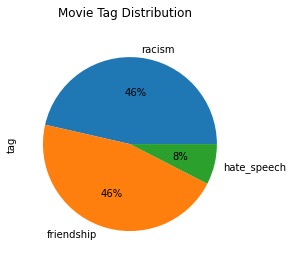

In [49]:
movie_metadata_df.tag.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Movie Tag Distribution')

In [50]:
movie_path = 'movies/racism/12 Years a Slave_conv.csv'

In [51]:
def annotate_single_movie(movie_df):
    utterances = movie_df.dialog.values
    predictions = []
    batch = []
    
    for text in utterances:
        # Dimension, 196609
        layer = np.zeros(total_words,dtype=float)

        for word in text.split(' '):
            layer[word2index[word.lower()]] += 1

        batch.append(layer)
        
    texts = torch.FloatTensor(batch).to('cuda')
    outputs = news_net(texts)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend([x.item() for x in predicted])

    result = []
    
    for i, pred in enumerate(predictions):
        result.append({'index': i, 'label_word_embedding_fox_news': categories[pred]})
    
    result_df = pd.DataFrame(result)
    movie_df = movie_df.merge(result_df, right_index=True, left_index=True)
    
    del movie_df['Unnamed: 0']
    del movie_df['index']
    
    return movie_df

## Annotate Movies

In [52]:
def movie_data_cleansing(df):
    df = df.replace(r'<[^\\]>', '', regex=True)
    df = df.replace(r'<\\.*>', '', regex=True)
    return df

In [53]:
movie_df = pd.read_csv('movies/racism/12 Angry Men_conv.csv')

In [54]:
movie_df.head()

,Unnamed: 0,dialog
0,0,"Thank you very much, sir."
1,1,You did a wonderful job. Wonderful.
2,2,Shh. Shh.
3,3,"We did it, Pete. We did it."
4,4,"For a moment, we had our doubts."


In [55]:
annotate_single_movie(movie_df)

,dialog,label_word_embedding_fox_news
0,"Thank you very much, sir.",not hate speech
1,You did a wonderful job. Wonderful.,not hate speech
2,Shh. Shh.,not hate speech
3,"We did it, Pete. We did it.",not hate speech
4,"For a moment, we had our doubts.",hate speech
...,...,...
2060,What's your name?,not hate speech
2061,Davis.,not hate speech
2062,My name's McCardle.,not hate speech
2063,"Well, so long.",hate speech


In [56]:
def annotate_movies(movie_metadata_df):
    
    pathes = movie_metadata_df.path.values
    tags = movie_metadata_df.tag.values
    movie_names = movie_metadata_df.movie_name.values
    
    result = []
    for i in range(0, movie_metadata_df.shape[0]):
        path = pathes[i]
        tag = tags[i]
        movie_name = movie_names[i]
        print(i+1, movie_metadata_df.shape[0], path, tag, movie_name)
        movie_df = pd.read_csv(path)
        movie_df = movie_data_cleansing(movie_df)
        movie_df = annotate_single_movie(movie_df)
        
        labels = movie_df.label_word_embedding_fox_news.values
                
        for i in range(0, len(labels)):
            result.append({'movie_name': movie_name, 'index': i, 'label': labels[i] })
                    
    result_df = pd.DataFrame(result)     
    return result_df

In [57]:
movies_annotated_df = annotate_movies(movie_metadata_df)

0 252 movies/racism//12 Angry Men_conv.csv racism 12 Angry Men
1 252 movies/racism//12 Years a Slave_conv.csv racism 12 Years a Slave
2 252 movies/racism//42_conv.csv racism 42
3 252 movies/racism//A Bronx Tale_conv.csv racism A Bronx Tale
4 252 movies/racism//A Time to Kill_conv.csv racism A Time to Kill
5 252 movies/racism//AI Artificial Intelligence_conv.csv racism AI Artificial Intelligence
6 252 movies/racism//American History X_conv.csv racism American History X
7 252 movies/racism//Amistad_conv.csv racism Amistad
8 252 movies/racism//Angel Heart_conv.csv racism Angel Heart
9 252 movies/racism//Antebellum_conv.csv racism Antebellum
10 252 movies/racism//Apocalypse Now_conv.csv racism Apocalypse Now
11 252 movies/racism//Bad Boys II_conv.csv racism Bad Boys II
12 252 movies/racism//Bend It Like Beckham_conv.csv racism Bend It Like Beckham
13 252 movies/racism//Blood Father_conv.csv racism Blood Father
14 252 movies/racism//Bone Tomahawk_conv.csv racism Bone Tomahawk
15 252 movies/

In [58]:
movies_annotated_df.to_csv('annotations_word_embedding_fox_news.csv')